In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Data Handling 

In [3]:
base_path = "../Data/btc_final_df.csv"
lstm_path = "../Results/btc_lstm_prediction.csv"
egarch_path = "../Results/btc_egarch_prediction.csv"
xgb_path = "../Results/btc_xgb_prediction.csv"


df = pd.read_csv(base_path, parse_dates=["timestamp"])
need = ["timestamp", "open", "low", "high", "close", "vol_future"]
df = df[need].copy()


if df["timestamp"].dt.tz is None:
    df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")
df = df.drop_duplicates(subset="timestamp").sort_values("timestamp")


def load_pred(path, new_col_name):
    d = pd.read_csv(path, parse_dates=["timestamp"])
    if d["timestamp"].dt.tz is None:
        d["timestamp"] = d["timestamp"].dt.tz_localize("UTC")
    pred_col = None
    for c in d.columns:
        if c.lower() in {"pred_vol_future"}:
            pred_col = c
            break
    if pred_col is None:
        raise ValueError(f"Could not find prediction column in {path}.")
    d = d[["timestamp", pred_col]].rename(columns={pred_col: new_col_name})
    return d.drop_duplicates(subset="timestamp").sort_values("timestamp")

lstm = load_pred(lstm_path, "lstm_pred_vol_future")
egarch = load_pred(egarch_path, "egarch_pred_vol_future")
xgb = load_pred(xgb_path, "xgb_pred_vol_future")  

master = (df
          .merge(lstm,  on="timestamp", how="left")
          .merge(egarch, on="timestamp", how="left")
          .merge(xgb,   on="timestamp", how="left"))

print("Initial:",len(master))

Initial: 8208


In [4]:
master = master.dropna(subset=[
    "lstm_pred_vol_future",
    "egarch_pred_vol_future",
    "xgb_pred_vol_future"
]).reset_index(drop=True)

print("After dropping NaNs:", len(master), "rows remain.")
print(master.head(3))
print(master.tail(3))

pred_cols = [c for c in ["lstm_pred_vol_future","egarch_pred_vol_future",
                         "xgb_pred_vol_future","tf_pred_vol_future"] if c in master.columns]



After dropping NaNs: 1208 rows remain.
                  timestamp       open        low       high      close  \
0 2025-08-23 16:00:00+00:00  114824.68  114699.35  114964.86  114964.86   
1 2025-08-23 17:00:00+00:00  114987.13  114943.52  115089.33  115061.31   
2 2025-08-23 18:00:00+00:00  115060.14  115035.54  115117.39  115112.79   

   vol_future  lstm_pred_vol_future  egarch_pred_vol_future  \
0    0.001425              0.002926                0.002982   
1    0.001241              0.002479                0.002805   
2    0.001540              0.002281                0.002674   

   xgb_pred_vol_future  
0             0.004060  
1             0.003855  
2             0.003855  
                     timestamp       open        low       high      close  \
1205 2025-10-12 21:00:00+00:00  115124.69  114573.45  115503.13  114757.84   
1206 2025-10-12 22:00:00+00:00  114973.28  114973.28  115577.73  115540.33   
1207 2025-10-12 23:00:00+00:00  115458.48  114932.12  115458.48  115208.8

Adding Backtesting Parameters

In [5]:
ALPHAS     = (0.80, 0.85, 0.90, 0.95)    # looser threshold range → more trades, 
Q_WINDOW   = 24*7                        # 7-day rolling window (keep this)
VAL_H      = 24*30                       # 30 days validation (more stable α selection)
TEST_H     = 24*5                        # 5 days test (shorter, rolling forward faster)
EMBARGO_H  = 1                           # keep small gap

FEE_RATE   = 0.001                      # 0.05% per side (test sensitivity to fees)
SPEND_FRAC = 0.05                        # same (or lower to reduce overtrading)
TP_PCT     = 0.02                        # widen target (+2%)
TSL_PCT    = 0.01                        # wider trailing stop (–1%)
INIT_CASH  = 10000.0
H_PER_YR   = 24*365


Features (returns) & utilities

In [6]:
master["ret_log"] = np.log(master["close"]).diff()
master["ret_2h"]  = master["ret_log"].rolling(2).sum()

def rolling_quantile(series, window, alpha):
    # use ONLY past data: shift by 1 hour to avoid look-ahead
    return series.shift(1).rolling(window=window, min_periods=max(6, window//2)).quantile(alpha)

def build_enter_flags(df, pred_col, alpha, q_window, mode):
    q = rolling_quantile(df["vol_future"], q_window, alpha)
    spike = (df[pred_col] > q)
    if mode == "momentum":
        cond = df["ret_2h"] > 0
    elif mode == "meanrev":
        cond = df["ret_2h"] < 0
    else:
        raise ValueError("mode must be 'momentum' or 'meanrev'")

    sig = (spike & cond).astype(bool)
    # decide at hour h close; EXECUTE next hour open
    return sig.shift(1, fill_value=False)



Broker backtest engines

In [7]:
def backtest_block(df_blk, enter_flags,
                   fee_rate=FEE_RATE, spend_frac=SPEND_FRAC,
                   tp=TP_PCT, tsl=TSL_PCT, initial_cash=INIT_CASH):
    
    cash = float(initial_cash)
    qty = 0.0
    entry_px = np.nan
    eq_rows = []
    trades = []
    idx = df_blk.index

    for i in range(1, len(idx)-1):
        t  = idx[i]      
        t1 = idx[i+1]    

        if qty != 0.0:
            px_in = entry_px
            high = df_blk.at[t1, "high"]
            low  = df_blk.at[t1, "low"]
            peak = max(px_in, high)
            stop_lvl   = peak * (1 - tsl)
            target_lvl = px_in * (1 + tp)

            if low <= stop_lvl:
                exit_px, reason = stop_lvl, "TSL"
            elif high >= target_lvl:
                exit_px, reason = target_lvl, "TP"
            else:
                exit_px, reason = df_blk.at[t1, "open"], "Timeout"

            proceeds = qty * exit_px * (1 - fee_rate)
            cash += proceeds
            trades.append(dict(ts=t1, side="SELL", qty=qty, price=exit_px,
                               fee=qty*exit_px*fee_rate, reason=reason))
            qty = 0.0
            entry_px = np.nan

        if bool(enter_flags.loc[t]) and qty == 0.0:
            px_open  = df_blk.at[t, "open"]
            notional = cash * spend_frac
            if px_open > 0 and notional > 0:
                qty = notional / (px_open * (1 + fee_rate))
                cash -= qty * px_open * (1 + fee_rate)
                entry_px = px_open
                trades.append(dict(ts=t, side="BUY", qty=qty, price=px_open,
                                   fee=qty*px_open*fee_rate, reason="Enter"))

        eq_rows.append((t, cash + qty * df_blk.at[t, "close"]))

    eq = pd.DataFrame(eq_rows, columns=["timestamp","equity"]).set_index("timestamp")
    tr = pd.DataFrame(trades)
    return eq, tr, cash

def buy_and_hold_global(df_full, fee_rate=FEE_RATE, initial_cash=INIT_CASH):
    cash = float(initial_cash)
    px_in = df_full.iloc[0]["open"]
    qty = cash / (px_in * (1 + fee_rate))
    cash -= qty * px_in * (1 + fee_rate)
    equity = []
    for i in range(len(df_full)):
        t = df_full.index[i]
        px = df_full.iloc[i]["close"]
        equity.append((t, cash + qty * px))
    return pd.DataFrame(equity, columns=["timestamp","equity"]).set_index("timestamp")

def buy_and_hold_over_windows(df_full, windows,
                              fee_rate=FEE_RATE, initial_cash=INIT_CASH):
    if not windows:
        return pd.DataFrame(columns=["equity"])

    cash = float(initial_cash)
    qty  = 0.0
    eq_rows = []
    first = True

    for (test_start, test_end) in windows:
        seg = df_full.loc[test_start:test_end]
        if seg.empty:
            continue
        # Enter at first bar open of the FIRST segment
        if first:
            px_in = seg.iloc[0]["open"]
            qty   = cash / (px_in * (1 + fee_rate))
            cash -= qty * px_in * (1 + fee_rate)
            first = False
        # Mark to market across this segment
        for i in range(len(seg)):
            t  = seg.index[i]
            px = seg.iloc[i]["close"]
            eq_rows.append((t, cash + qty * px))

    return pd.DataFrame(eq_rows, columns=["timestamp","equity"]).set_index("timestamp")


Metrics

In [8]:
def metrics(eq):
    ret = eq["equity"].pct_change().dropna()
    if len(ret)==0 or ret.std()==0:
        return pd.Series(dict(Sharpe=np.nan, Sortino=np.nan, MaxDD=np.nan,
                              Calmar=np.nan, TotalRet=np.nan, VaR95=np.nan))
    sharpe  = np.sqrt(H_PER_YR) * ret.mean() / ret.std()
    downside= ret[ret<0]
    sortino = np.sqrt(H_PER_YR) * ret.mean() / (downside.std() if downside.std() > 0 else np.nan)
    curve   = eq["equity"]
    maxdd   = (curve/curve.cummax() - 1).min()
    total   = curve.iloc[-1] / curve.iloc[0] - 1
    var95   = np.percentile(ret, 5)
    calmar  = (total + 1e-12) / abs(maxdd) if maxdd < 0 else np.nan
    return pd.Series(dict(Sharpe=sharpe, Sortino=sortino, MaxDD=maxdd,
                          Calmar=calmar, TotalRet=total, VaR95=var95))


Walk Forward Logic 

In [14]:
def walk_forward_per_model(df_full, pred_col, mode,
                           alphas=ALPHAS, q_window=Q_WINDOW,
                           val_hours=VAL_H, test_hours=TEST_H, embargo_hours=EMBARGO_H,
                           fee_rate=FEE_RATE, spend_frac=SPEND_FRAC, tp=TP_PCT, tsl=TSL_PCT,
                           initial_cash=INIT_CASH):

    idx = df_full.index.to_list()  # ensure index slicing works properly
    end = len(idx)
    warmup = max(q_window + 2, 10)
    i = warmup

    eq_segments, trade_segments, chosen_rows, test_windows = [], [], [], []
    cash_carry = float(initial_cash)

    while True:
        val_end = i + val_hours
        test_start = val_end + embargo_hours
        test_end = test_start + test_hours
        if test_end >= end:
            break

        val_idx  = idx[i:val_end]
        test_idx = idx[test_start:test_end]

        # Find best α on validation window
        best_alpha, best_sharpe = None, -np.inf
        for a in alphas:
            enter_val = build_enter_flags(df_full, pred_col, a, q_window, mode).reindex(val_idx)
            eq_val, _, _ = backtest_block(
                df_full.loc[val_idx], enter_val,
                fee_rate=fee_rate, spend_frac=spend_frac, tp=tp, tsl=tsl,
                initial_cash=initial_cash
            )
            ret = eq_val["equity"].pct_change().dropna()
            if not ret.empty and ret.std() > 0:
                sharpe = np.sqrt(H_PER_YR) * ret.mean() / ret.std()
            else:
                sharpe = -np.inf
            if sharpe > best_sharpe:
                best_sharpe, best_alpha = sharpe, a

        # Record chosen α and Sharpe for this block
        chosen_rows.append({
            "val_start": idx[i],
            "val_end": idx[val_end - 1],
            "test_start": idx[test_start],
            "test_end": idx[test_end - 1],
            "chosen_alpha": best_alpha,
            "val_sharpe": best_sharpe
        })
        test_windows.append((idx[test_start], idx[test_end - 1]))

        #  Apply α on test block
        enter_test = build_enter_flags(df_full, pred_col, best_alpha, q_window, mode).reindex(test_idx)
        eq_test, tr_test, cash_carry = backtest_block(
            df_full.loc[test_idx], enter_test,
            fee_rate=fee_rate, spend_frac=spend_frac, tp=tp, tsl=tsl,
            initial_cash=cash_carry
        )

        eq_segments.append(eq_test)
        tr_test["chosen_alpha"] = best_alpha
        trade_segments.append(tr_test)

        i = test_end  # advance window

    # Combine results
    equity_oos = (
        pd.concat(eq_segments).sort_index()
        if eq_segments else pd.DataFrame(columns=["equity"])
    )
    trades_oos = (
        pd.concat(trade_segments, ignore_index=True)
        if trade_segments else pd.DataFrame()
    )
    chosen_log = pd.DataFrame(chosen_rows)
    summary = metrics(equity_oos).to_frame().T if not equity_oos.empty else pd.DataFrame()

    return {
        "equity": equity_oos,
        "trades": trades_oos,
        "chosen_alpha_log": chosen_log,
        "summary": summary,
        "test_windows": test_windows
    }


#store results 
results_by_tag = {}           

for pred_col in ["lstm_pred_vol_future","egarch_pred_vol_future","xgb_pred_vol_future"]:
    for mode in ["momentum","meanrev"]:
        tag = f"{pred_col}__{mode}"
        results_by_tag[tag] = walk_forward_per_model(master, pred_col, mode)


Chosen alpha by block 

In [10]:
alpha_rows = []

for tag, res in results_by_tag.items():
    log = res.get("chosen_alpha_log")
    if log is None or log.empty:
        continue

    # tag looks like "xgb_pred_vol_future__momentum"
    parts = tag.split("__")
    model = parts[0]
    strategy = parts[1] if len(parts) > 1 else "NA"

    tmp = log[["val_start","val_end","test_start","test_end","chosen_alpha","val_sharpe"]].copy()
    tmp["Model"] = model
    tmp["Strategy"] = strategy
    alpha_rows.append(tmp)

alpha_table = (
    pd.concat(alpha_rows, ignore_index=True)
      .sort_values(["test_start","Model","Strategy"])
      .reset_index(drop=True)
)

print("\n=== Chosen α by block (per model × strategy) ===")
print(alpha_table.to_string(index=False))



=== Chosen α by block (per model × strategy) ===
 val_start  val_end  test_start  test_end  chosen_alpha  val_sharpe                  Model Strategy
       170      889         891      1010          0.95   -0.394790 egarch_pred_vol_future  meanrev
       170      889         891      1010          0.95   -5.668301 egarch_pred_vol_future momentum
       170      889         891      1010          0.90   -1.769310   lstm_pred_vol_future  meanrev
       170      889         891      1010          0.90   -3.154584   lstm_pred_vol_future momentum
       170      889         891      1010          0.90   -9.288991    xgb_pred_vol_future  meanrev
       170      889         891      1010          0.90  -10.752583    xgb_pred_vol_future momentum


Trades per test block

In [11]:
trade_rows = []

# Loop through all model-strategy results
for tag, res in results_by_tag.items():
    tr = res.get("trades")
    log = res.get("chosen_alpha_log")

    if tr is None or tr.empty or log is None or log.empty:
        continue

    model, strategy = tag.split("__")

    # For each validation-test block in chosen_alpha_log
    for _, r in log.iterrows():
        mask = (tr["ts"] >= r["test_start"]) & (tr["ts"] <= r["test_end"])
        trade_rows.append({
            "Model": model,
            "Strategy": strategy,
            "test_start": r["test_start"],
            "test_end": r["test_end"],
            "trades_in_block": int(mask.sum()),
            "chosen_alpha": r["chosen_alpha"]
        })

# Combine into one DataFrame
trades_per_block = (
    pd.DataFrame(trade_rows)
      .sort_values(["test_start", "Model", "Strategy"])
      .reset_index(drop=True)
)

print("\n=== Trades per test block ===")
print(trades_per_block.to_string(index=False))



=== Trades per test block ===
                 Model Strategy  test_start  test_end  trades_in_block  chosen_alpha
egarch_pred_vol_future  meanrev       891.0    1010.0                2          0.95
egarch_pred_vol_future momentum       891.0    1010.0               12          0.95
  lstm_pred_vol_future  meanrev       891.0    1010.0               12          0.90
  lstm_pred_vol_future momentum       891.0    1010.0               30          0.90
   xgb_pred_vol_future  meanrev       891.0    1010.0               62          0.90
   xgb_pred_vol_future momentum       891.0    1010.0               96          0.90


Equity Curves for each model and strategy 

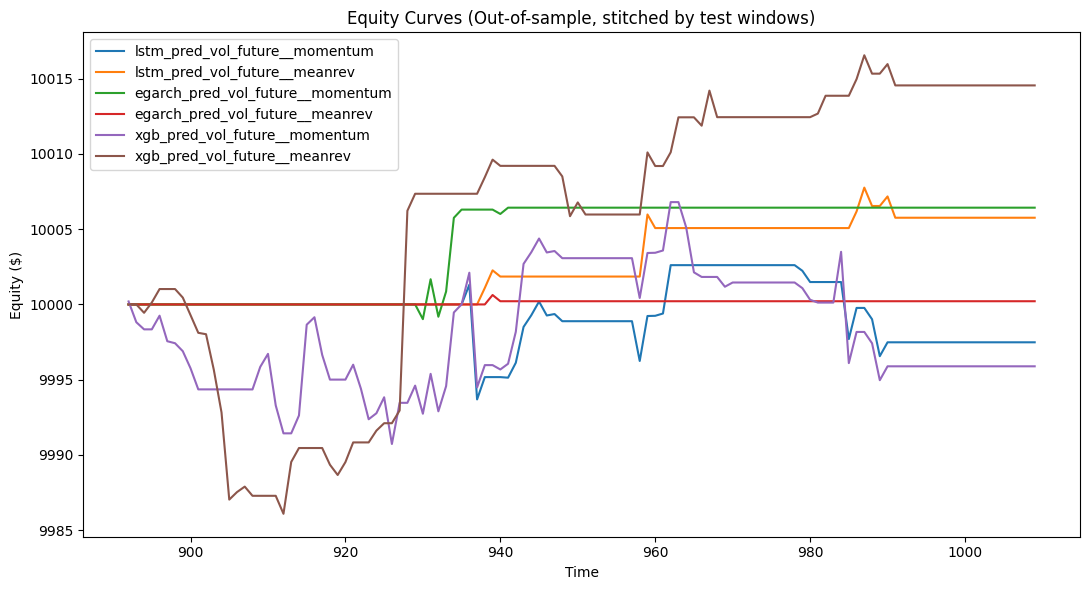


=== Equity Summary (OOS) ===
                                   FinalEquity  TotalReturn
xgb_pred_vol_future__meanrev      10014.558939     0.001456
egarch_pred_vol_future__momentum  10006.431690     0.000643
lstm_pred_vol_future__meanrev     10005.763060     0.000576
egarch_pred_vol_future__meanrev   10000.212983     0.000021
lstm_pred_vol_future__momentum     9997.483057    -0.000252
xgb_pred_vol_future__momentum      9995.886921    -0.000431


In [12]:
# Gather equity curves from results_by_tag
all_equity = {}

for tag, res in results_by_tag.items():
    eq = res.get("equity")
    if eq is None or eq.empty:
        continue

    # Accept different shapes (timestamp as column or as index)
    if "timestamp" in eq.columns:
        e = (eq[["timestamp", "equity"]]
             .dropna()
             .set_index("timestamp")
             .sort_index())
    elif "ts" in eq.columns:
        e = (eq[["ts", "equity"]]
             .rename(columns={"ts": "timestamp"})
             .dropna()
             .set_index("timestamp")
             .sort_index())
    else:
        # assume index already is the timestamp
        e = eq[["equity"]].copy()
        e.index.name = "timestamp"

    e["equity"] = e["equity"].astype(float)
    all_equity[tag] = e

# Outer-join all equity series by timestamp
equity_panel = (
    pd.concat({tag: df["equity"] for tag, df in all_equity.items()}, axis=1)
      .sort_index()
)


plt.figure(figsize=(11,6))
for col in equity_panel.columns:
    plt.plot(equity_panel.index, equity_panel[col], label=col)
plt.legend(loc="best")
plt.title("Equity Curves (Out-of-sample, stitched by test windows)")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.tight_layout()
plt.show()

first_row = equity_panel.dropna(how="all").iloc[0]
last_row  = equity_panel.ffill().iloc[-1]

equity_summary = pd.DataFrame({
    "FinalEquity": last_row,
    "TotalReturn": (last_row / first_row) - 1.0
}).sort_values("FinalEquity", ascending=False)

print("\n=== Equity Summary (OOS) ===")
print(equity_summary.to_string())


Summary of Results 

In [13]:
pred_cols_present = [c for c in pred_cols if c in master.columns]
modes = ["momentum", "meanrev"]

all_summaries = []
all_equities  = {}
all_trades    = {}
all_choices   = {}

# Global Buy & Hold (full period)
bh_global = buy_and_hold_global(master)

for m in pred_cols_present:
    for mode in modes:
        res = walk_forward_per_model(
            master, pred_col=m, mode=mode,
            alphas=ALPHAS, q_window=Q_WINDOW,
            val_hours=VAL_H, test_hours=TEST_H, embargo_hours=EMBARGO_H,
            fee_rate=FEE_RATE, spend_frac=SPEND_FRAC, tp=TP_PCT, tsl=TSL_PCT,
            initial_cash=INIT_CASH
        )
        tag = m + "__" + mode
        all_equities[tag] = res["equity"]
        all_trades[tag]   = res["trades"]
        all_choices[tag]  = res["chosen_alpha_log"]
        s = res["summary"].copy()
        s.insert(0, "Model", m)
        s.insert(1, "Strategy", mode)
        all_summaries.append(s)

# Build a stitched Buy&Hold over the SAME test windows 
all_windows = []
for v in all_choices.values():
    if not v.empty:
        for _, r in v.iterrows():
            all_windows.append((r["test_start"], r["test_end"]))
all_windows = sorted(list(set(all_windows)))
bh_stitched = buy_and_hold_over_windows(master, all_windows)

# Collect summaries
summary_table = pd.concat(all_summaries, ignore_index=True) if all_summaries else pd.DataFrame()
if not bh_global.empty:
    s_bh_global = metrics(bh_global).to_frame().T
    s_bh_global.insert(0, "Model", "Buy&Hold_Global")
    s_bh_global.insert(1, "Strategy", "Hold")
    summary_table = pd.concat([summary_table, s_bh_global], ignore_index=True)

if not bh_stitched.empty:
    s_bh_stitch = metrics(bh_stitched).to_frame().T
    s_bh_stitch.insert(0, "Model", "Buy&Hold_Stitched")
    s_bh_stitch.insert(1, "Strategy", "Hold(test-windows)")
    summary_table = pd.concat([summary_table, s_bh_stitch], ignore_index=True)

print(summary_table.round(4))


                    Model            Strategy   Sharpe  Sortino   MaxDD  \
0    lstm_pred_vol_future            momentum  -1.9407  -0.8650 -0.0008   
1    lstm_pred_vol_future             meanrev   9.3969  10.5423 -0.0002   
2  egarch_pred_vol_future            momentum   8.6322   4.5651 -0.0002   
3  egarch_pred_vol_future             meanrev   2.4460      NaN -0.0000   
4     xgb_pred_vol_future            momentum  -1.9628  -1.9272 -0.0012   
5     xgb_pred_vol_future             meanrev   7.2182   9.3185 -0.0015   
6         Buy&Hold_Global                Hold   0.2113   0.2519 -0.1278   
7       Buy&Hold_Stitched  Hold(test-windows)  16.4235  29.8634 -0.0147   

   Calmar  TotalRet   VaR95  
0 -0.3302   -0.0003 -0.0001  
1  2.8807    0.0006  0.0000  
2  2.5803    0.0006  0.0000  
3  0.5152    0.0000  0.0000  
4 -0.3645   -0.0004 -0.0003  
5  0.9746    0.0015 -0.0001  
6  0.0166    0.0021 -0.0049  
7  4.3584    0.0643 -0.0027  
